<a href="https://colab.research.google.com/github/benmsanderson/SRMfair/blob/main/FAIR_timeshift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Normal setup

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

In [ ]:
def plot_shaded(tim,dist,col,ax,label=None):
      #for pp in ((1, 99), (5, 95), (16, 84)):
      for pp in [(5, 95)]:

        ax.fill_between(
            tim,
            np.percentile(
                dist,
                pp[0],
                axis=1,
            ),
            np.percentile(
                dist,
                pp[1],
                axis=1,
            ),
            color=col,
            alpha=0.1,
            lw=0
        )

      ax.plot(
          tim,
          np.median(
              dist,
              axis=1,
          ),
          color=col,
          label=label
        )

In [ ]:
def range_plot(ax,fld,scenario,col,label=None):
    dist=fld.loc[dict(scenario=scenario)]
    tim=f.timebounds
    plot_shaded(tim[:dist.shape[0]],dist,col,ax,label)

In [ ]:
pip install fair

## 0. Get required imports

[pooch](https://www.fatiando.org/pooch/latest/) is a useful package that allows downloads of external datasets to your cache, meaning that you don't have to include them in Git repositories (particularly troublesome for large files) or `.gitignore` them (difficult for exact reproduciblity, and easy to forget and accidently commit a large file).

In [ ]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import pooch

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

## 1. Create FaIR instance


In [ ]:
f = FAIR(ch4_method="Thornhill2021")
## 2. Define time horizon

f.define_time(1750, 2300, 1)  # start, end, step
## 3. Define scenarios

#scenarios = ["ssp119", "ssp126", "ssp245", "ssp370", "ssp434", "ssp460", "ssp534-over", "ssp585"]
scenarios = ["ssp119","ssp126"]
f.define_scenarios(scenarios)

## 4. Define configs



In [ ]:
fair_params_1_2_0_obj = pooch.retrieve(
    url = 'https://zenodo.org/record/8399112/files/calibrated_constrained_parameters.csv',
    known_hash = 'md5:de3b83432b9d071efdd1427ad31e9076',
)

In [ ]:
df_configs = pd.read_csv(fair_params_1_2_0_obj, index_col=0)



In [ ]:
configs = df_configs.index  # this is used as a label for the "config" axis


In [ ]:
f.define_configs(configs)

Make a config dataframe with half kappa2 values

In [ ]:

species, properties = read_properties(filename='https://raw.githubusercontent.com/OMS-NetZero/FAIR/master/examples/data/species_configs_properties_calibration1.2.0.csv')
f.define_species(species, properties)

f.allocate()

## 8. Fill in data

### 8a. emissions, solar forcing, and volcanic forcing

We can use the convenience function `fill_from_rcmip()` to fill in the emissions. Remember that not all `species` are things that take emissions, so if you see NaNs below, don't panic.

In [ ]:
f.fill_from_rcmip()

Fix Nox

In [ ]:
rcmip_emissions_file = pooch.retrieve(
    url="doi:10.5281/zenodo.4589756/rcmip-emissions-annual-means-v5-1-0.csv",
    known_hash="md5:4044106f55ca65b094670e7577eaf9b3",
)
df_emis = pd.read_csv(rcmip_emissions_file)
gfed_sectors = [
    "Emissions|NOx|MAGICC AFOLU|Agricultural Waste Burning",
    "Emissions|NOx|MAGICC AFOLU|Forest Burning",
    "Emissions|NOx|MAGICC AFOLU|Grassland Burning",
    "Emissions|NOx|MAGICC AFOLU|Peat Burning",
]
for scenario in scenarios:
    f.emissions.loc[dict(specie="NOx", scenario=scenario)] = (
        df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"].isin(gfed_sectors)),
            "1750":"2300",
        ]
        .interpolate(axis=1)
        .values.squeeze()
        .sum(axis=0)
        * 46.006
        / 30.006
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC AFOLU|Agriculture"),
            "1750":"2300",
        ]
        .interpolate(axis=1)
        .values.squeeze()
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC Fossil and Industrial"),
            "1750":"2300",
        ]
        .interpolate(axis=1)
        .values.squeeze()
    )[:550, None]

Now we fetch and fill in the solar and volcanic forcing. As these are forcing-driven time series, if we want to vary the uncertainties in the forcing, this has to happen before FaIR is run (see https://github.com/OMS-NetZero/FAIR/issues/126).

In [ ]:
solar_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-add-hfc/main/data/solar_erf_timebounds.csv',
    known_hash = 'md5:98f6f4c5309d848fea89803683441acf',
)

In [ ]:
volcanic_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-calibrate/main/data/forcing/volcanic_ERF_1750-2101_timebounds.csv',
    known_hash = 'md5:c0801f80f70195eb9567dbd70359219d',
)

In [ ]:
df_solar = pd.read_csv(solar_obj, index_col="year")
df_volcanic = pd.read_csv(volcanic_obj)

In [ ]:
solar_forcing = np.zeros(551)
volcanic_forcing = np.zeros(551)
volcanic_forcing[:352] = df_volcanic.erf.values
solar_forcing = df_solar["erf"].loc[1750:2300].values

trend_shape = np.ones(551)
trend_shape[:271] = np.linspace(0, 1, 271)

We then use our calibrated, constrained ensemble to individually scale the volcanic forcing time series, and the solar amplitude and trend:

In [ ]:
fill(
    f.forcing,
    volcanic_forcing[:, None, None] * df_configs["fscale_Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    solar_forcing[:, None, None] * df_configs["fscale_solar_amplitude"].values.squeeze()
    + trend_shape[:, None, None] * df_configs["fscale_solar_trend"].values.squeeze(),
    specie="Solar",
)

### 8b. Fill in climate_configs

This is relatively straightforward from the calibrated, constrained dataset.

In [ ]:
fill(f.climate_configs["ocean_heat_capacity"], df_configs.loc[:, "clim_c1":"clim_c3"].values)

fill(f.climate_configs["deep_ocean_efficacy"], df_configs["clim_epsilon"].values.squeeze())
fill(f.climate_configs["gamma_autocorrelation"], df_configs["clim_gamma"].values.squeeze())
fill(f.climate_configs["sigma_eta"], df_configs["clim_sigma_eta"].values.squeeze())
fill(f.climate_configs["sigma_xi"], df_configs["clim_sigma_xi"].values.squeeze())
fill(f.climate_configs["seed"], df_configs["seed"])
fill(f.climate_configs["stochastic_run"], False)
fill(f.climate_configs["use_seed"], False)
fill(f.climate_configs["forcing_4co2"], df_configs["clim_F_4xCO2"])

In [ ]:
fill(
    f.climate_configs["ocean_heat_transfer"],
    df_configs.loc[:, "clim_kappa1":"clim_kappa3"].values,
)

### 8c. Fill in species_configs

Firstly we want to get the defaults from our new species/properties/configs file

In [ ]:
f.fill_species_configs(filename='https://raw.githubusercontent.com/OMS-NetZero/FAIR/master/examples/data/species_configs_properties_calibration1.2.0.csv')

Then, we overwrite the `species_configs` that are varies as part of the probablistic sampling. This makes heavy use of the `fill()` convenience function.

In [ ]:
# carbon cycle
fill(f.species_configs["iirf_0"], df_configs["cc_r0"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_airborne"], df_configs["cc_rA"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_uptake"], df_configs["cc_rU"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_temperature"], df_configs["cc_rT"].values.squeeze(), specie="CO2")

# aerosol indirect
fill(f.species_configs["aci_scale"], df_configs["aci_beta"].values.squeeze())
fill(f.species_configs["aci_shape"], df_configs["aci_shape_so2"].values.squeeze(), specie="Sulfur")
fill(f.species_configs["aci_shape"], df_configs["aci_shape_bc"].values.squeeze(), specie="BC")
fill(f.species_configs["aci_shape"], df_configs["aci_shape_oc"].values.squeeze(), specie="OC")

# aerosol direct
for specie in [
    "BC",
    "CH4",
    "N2O",
    "NH3",
    "NOx",
    "OC",
    "Sulfur",
    "VOC",
    "Equivalent effective stratospheric chlorine"
]:
    fill(f.species_configs["erfari_radiative_efficiency"], df_configs[f"ari_{specie}"], specie=specie)

# forcing scaling
for specie in [
    "CO2",
    "CH4",
    "N2O",
    "Stratospheric water vapour",
    "Contrails",
    "Light absorbing particles on snow and ice",
    "Land use"
]:
    fill(f.species_configs["forcing_scale"], df_configs[f"fscale_{specie}"].values.squeeze(), specie=specie)
# the halogenated gases all take the same scale factor
for specie in [
    "CFC-11",
    "CFC-12",
    "CFC-113",
    "CFC-114",
    "CFC-115",
    "HCFC-22",
    "HCFC-141b",
    "HCFC-142b",
    "CCl4",
    "CHCl3",
    "CH2Cl2",
    "CH3Cl",
    "CH3CCl3",
    "CH3Br",
    "Halon-1211",
    "Halon-1301",
    "Halon-2402",
    "CF4",
    "C2F6",
    "C3F8",
    "c-C4F8",
    "C4F10",
    "C5F12",
    "C6F14",
    "C7F16",
    "C8F18",
    "NF3",
    "SF6",
    "SO2F2",
    "HFC-125",
    "HFC-134a",
    "HFC-143a",
    "HFC-152a",
    "HFC-227ea",
    "HFC-23",
    "HFC-236fa",
    "HFC-245fa",
    "HFC-32",
    "HFC-365mfc",
    "HFC-4310mee",
]:
    fill(f.species_configs["forcing_scale"], df_configs["fscale_minorGHG"].values.squeeze(), specie=specie)

# ozone
for specie in ["CH4", "N2O", "Equivalent effective stratospheric chlorine", "CO", "VOC", "NOx"]:
    fill(f.species_configs["ozone_radiative_efficiency"], df_configs[f"o3_{specie}"], specie=specie)

# initial value of CO2 concentration (but not baseline for forcing calculations)
fill(
    f.species_configs["baseline_concentration"],
    df_configs["cc_co2_concentration_1750"].values.squeeze(),
    specie="CO2"
)

### 8d. Initial conditions

It's important these are defined, as they are NaN by default, and it's likely you'll run into problems.

In [ ]:
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

# Timewarp stuff


In [ ]:
emis_co2=f.emissions.loc[dict(scenario='ssp119',config=1230,specie='CO2 FFI')].copy()

Time shift function -

In [ ]:
def timewarp(tim_in,start,mid,end):
  # tim_in = input time vector
  # start = start time for accelerated timeline
  # mid = new time we get to the emissions at the original 'halfway' point
  # end = end time when we rejoin the original timeline
  tim_out=tim_in.copy()
  omid=0.5*(start+end)
  tim_out[(tim_in>=start)&(tim_in<mid)]=(np.arange(start,mid)-start)/(mid-start)*(omid-start)+start
  tim_out[(tim_in>=mid)&(tim_in<end)]=(np.arange(mid,end)-mid)/(end-mid)*(end-omid)+omid
  return tim_out

In [ ]:
acceltime=timewarp(f.emissions.timepoints.values,2025,2035,2075)

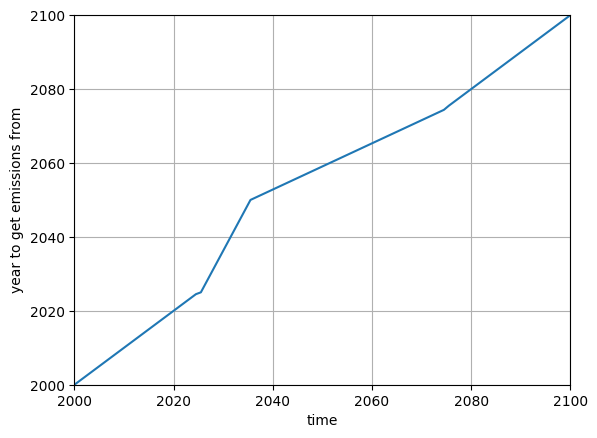

In [ ]:
plt.plot(f.emissions.timepoints.values,acceltime)
plt.xlabel('time')
plt.ylabel('year to get emissions from')
plt.xlim(2000,2100)
plt.ylim(2000,2100)
plt.grid()

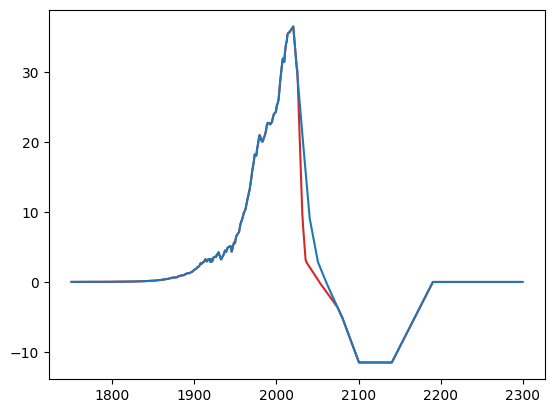

In [ ]:
plt.plot(f.emissions.timepoints.values,np.interp(acceltime,f.emissions.timepoints.values,emis_co2),'tab:red')
plt.plot(f.emissions.timepoints.values,emis_co2,'tab:blue')

In [ ]:
emis_acc=f.emissions.loc[dict(scenario='ssp119')].interp(timepoints=acceltime)

In [ ]:
emis_acc['timepoints'] = f.emissions.timepoints.values

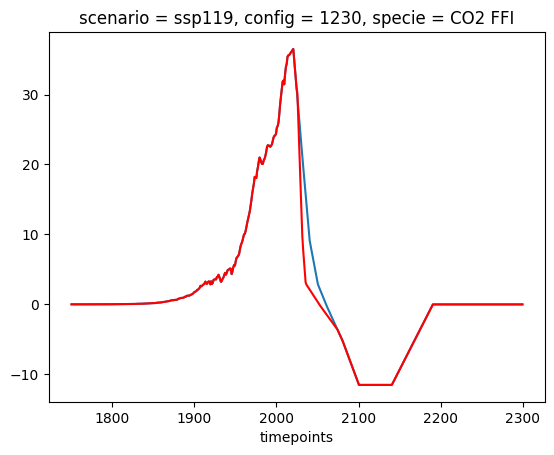

In [ ]:
f.emissions.loc[dict(scenario='ssp119',config=1230,specie='CO2 FFI')].plot()
emis_acc.loc[dict(config=1230,specie='CO2 FFI')].plot(color='r')


Using the SSP126 space to store the accelerated timeline because I can't work outn how to change the name

In [ ]:
f.emissions.loc[dict(scenario='ssp126')]=emis_acc

In [ ]:
f.run()


Running 2002 projections in parallel:   0%|          | 0/550 [00:00<?, ?timesteps/s]

Text(0, 0.5, 'Temperature anomaly (K)')

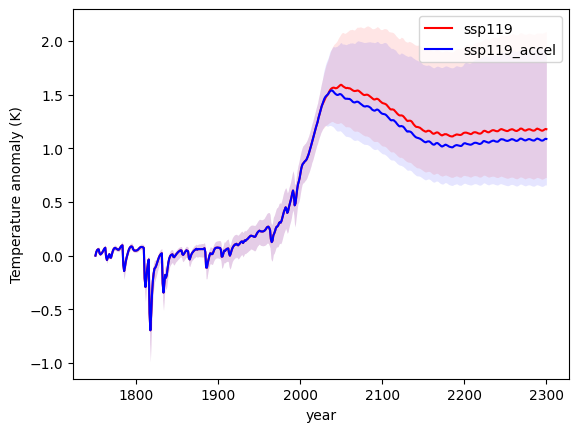

In [ ]:
#pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp126', layer=0)], label=f.configs);
p1=range_plot(plt.gca(),f.temperature.loc[dict( layer=0)],'ssp119','r', label='ssp119')
p1=range_plot(plt.gca(),f.temperature.loc[dict( layer=0)],'ssp126','b', label='ssp119_accel')
plt.legend()
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

Text(0, 0.5, 'FF CO2 emissions (GtCO2)')

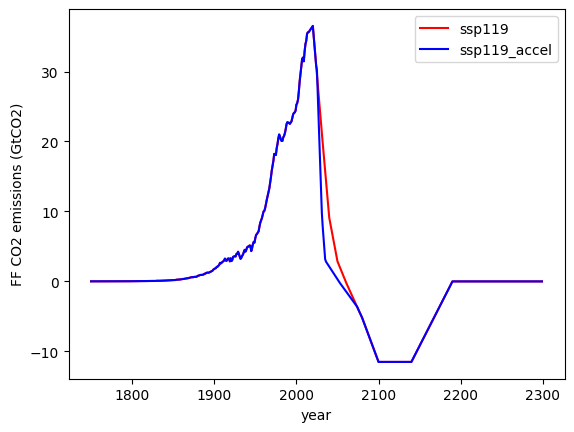

In [ ]:
#pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp126', layer=0)], label=f.configs);
p1=range_plot(plt.gca(),f.emissions.loc[dict( specie='CO2 FFI')],'ssp119','r', label='ssp119')
p1=range_plot(plt.gca(),f.emissions.loc[dict( specie='CO2 FFI')],'ssp126','b', label='ssp119_accel')
plt.legend()
pl.xlabel('year')
pl.ylabel('FF CO2 emissions (GtCO2)')

Text(0, 0.5, 'CH4 emissions')

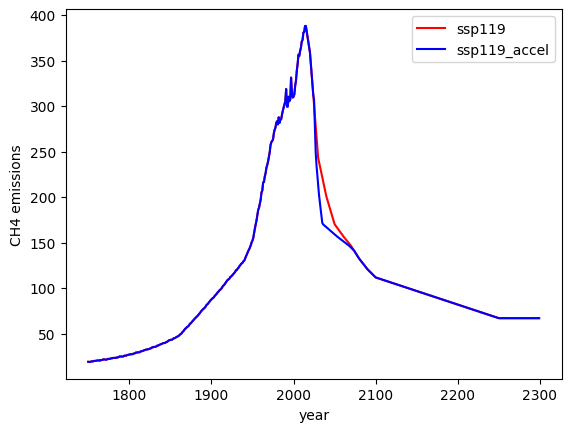

In [ ]:
#pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp126', layer=0)], label=f.configs);
p1=range_plot(plt.gca(),f.emissions.loc[dict( specie='CH4')],'ssp119','r', label='ssp119')
p1=range_plot(plt.gca(),f.emissions.loc[dict( specie='CH4')],'ssp126','b', label='ssp119_accel')
plt.legend()
pl.xlabel('year')
pl.ylabel('CH4 emissions')